<a href="https://colab.research.google.com/github/YAMINISARASWATHI04/DL-Assignment/blob/main/DLAssignment(Adam_and_Relu).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the dataset and plot sample images for each class.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andhikawb/fashion-mnist-png")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andhikawb/fashion-mnist-png/versions/1


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [ ]:
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/andhikawb/fashion-mnist-png/versions/1"  # Update with actual path
train_path = os.path.join(dataset_path, "train")


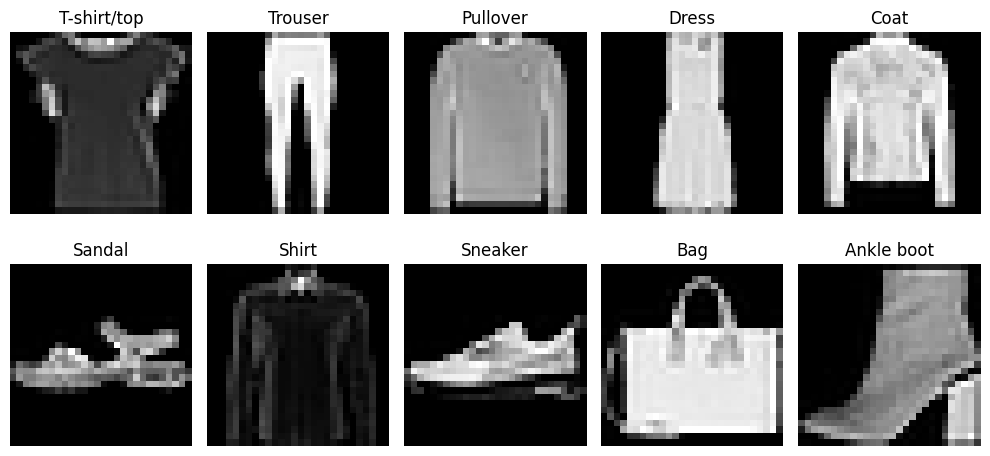

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, label in enumerate(class_labels):
    class_dir = os.path.join(train_path, str(i))
    sample_image = os.listdir(class_dir)[0]
    image_path = os.path.join(class_dir, sample_image)

    img = Image.open(image_path).convert("L")  # Open and convert to grayscale

    ax = axes[i // 5, i % 5]  # Subplot positioning
    ax.imshow(img, cmap="gray")
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Download and import Libraries

In [ ]:
# !pip install torch torchvision numpy matplotlib


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split


# Load and preprocess data

In [ ]:
# Define transformations (convert to tensor & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Split training dataset (90% train, 10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define class labels
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


# Define the Flexible Feedforward Neural Network

In [ ]:
class FlexibleFNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers=[128, 64], activation="relu", weight_init="xavier"):
        super(FlexibleFNN, self).__init__()

        layers = []
        prev_size = input_size

        # Activation function selection
        if activation == "relu":
            activation_fn = nn.ReLU()
        elif activation == "sigmoid":
            activation_fn = nn.Sigmoid()
        else:
            raise ValueError("Invalid activation function. Choose 'relu' or 'sigmoid'.")

        # Create hidden layers
        for hidden_size in hidden_layers:
            layer = nn.Linear(prev_size, hidden_size)

            # Apply weight initialization
            if weight_init == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            elif weight_init == "random":
                nn.init.uniform_(layer.weight, -0.1, 0.1)
            else:
                raise ValueError("Invalid weight initialization. Choose 'xavier' or 'random'.")

            layers.append(layer)
            layers.append(activation_fn)
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 10))  # 10 classes

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)


# Select Optimizer Based on User Choice

In [ ]:
def get_optimizer(optimizer_name, model_params, learning_rate, weight_decay):
    if optimizer_name == "sgd":
        return optim.SGD(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "momentum":
        return optim.SGD(model_params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "nesterov":
        return optim.SGD(model_params, lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    elif optimizer_name == "rmsprop":
        return optim.RMSprop(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "adam":
        return optim.Adam(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "nadam":
        return optim.NAdam(model_params, lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError("Invalid optimizer choice.")


# Train the Model

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, config_name, num_epochs=10):
    """Train the model and store validation accuracy for each epoch."""
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_accuracies = []  # Store validation accuracy for each epoch

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train

        # Compute Validation Accuracy
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%, Val Accuracy: {val_acc:.2f}%")

    # Store results for analysis
    experiment_results[config_name] = {
        "val_accuracies": val_accuracies,  # Store validation accuracies
        "model": model  # Store the trained model
    }

# Run the Model with Different Hyperparameters

In [ ]:
#  Hyperparameter Configuration
batch_size = 32
hidden_layers = [128, 64]
activation_fn = "relu"
weight_init = "xavier"
learning_rate = 1e-3
weight_decay = 0.0005
optimizer_name = "adam"
num_epochs = 10

# # Data Loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Initialize Model
# model = FlexibleFNN(hidden_layers=hidden_layers, activation=activation_fn, weight_init=weight_init)

# # Select Optimizer
# optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate, weight_decay)

# # Train Model
# train_model(model, train_loader, val_loader, optimizer, num_epochs)


# Run Experiments with Different Configurations


In [ ]:
experiment_results = {}  # Dictionary to store results

# Define different configurations
configs = [
    {"hidden_layers": [64, 32], "activation": "relu", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier"},
    {"hidden_layers": [128, 64], "activation": "relu", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "sgd", "batch_size": 32, "lr": 1e-3, "init": "xavier"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "momentum", "batch_size": 32, "lr": 1e-3, "init": "xavier"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "nesterov", "batch_size": 32, "lr": 1e-3, "init": "xavier"},
    {"hidden_layers": [128, 64, 32], "activation": "sigmoid", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier"},
    {"hidden_layers": [64, 32], "activation": "relu", "optimizer": "rmsprop", "batch_size": 32, "lr": 1e-3, "init": "xavier"}
]

# Train models with different configurations
for config in configs:
    print(f"\nTraining with config: {config}\n")

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = FlexibleFNN(hidden_layers=config["hidden_layers"], activation=config["activation"], weight_init=config["init"])
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"], weight_decay=0.0005)

    train_model(model, train_loader, val_loader, optimizer, str(config), num_epochs=10)



Training with config: {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier'}

Epoch [1/10], Loss: 0.5176, Train Accuracy: 81.25%, Val Accuracy: 83.72%
Epoch [2/10], Loss: 0.3974, Train Accuracy: 85.39%, Val Accuracy: 86.08%
Epoch [3/10], Loss: 0.3632, Train Accuracy: 86.71%, Val Accuracy: 85.65%
Epoch [4/10], Loss: 0.3504, Train Accuracy: 86.97%, Val Accuracy: 86.65%
Epoch [5/10], Loss: 0.3350, Train Accuracy: 87.65%, Val Accuracy: 85.68%
Epoch [6/10], Loss: 0.3258, Train Accuracy: 87.84%, Val Accuracy: 87.52%
Epoch [7/10], Loss: 0.3158, Train Accuracy: 88.29%, Val Accuracy: 86.68%
Epoch [8/10], Loss: 0.3100, Train Accuracy: 88.50%, Val Accuracy: 85.78%
Epoch [9/10], Loss: 0.3038, Train Accuracy: 88.79%, Val Accuracy: 86.48%
Epoch [10/10], Loss: 0.2989, Train Accuracy: 88.92%, Val Accuracy: 87.08%

Training with config: {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001,

# Plot Validation Accuracy

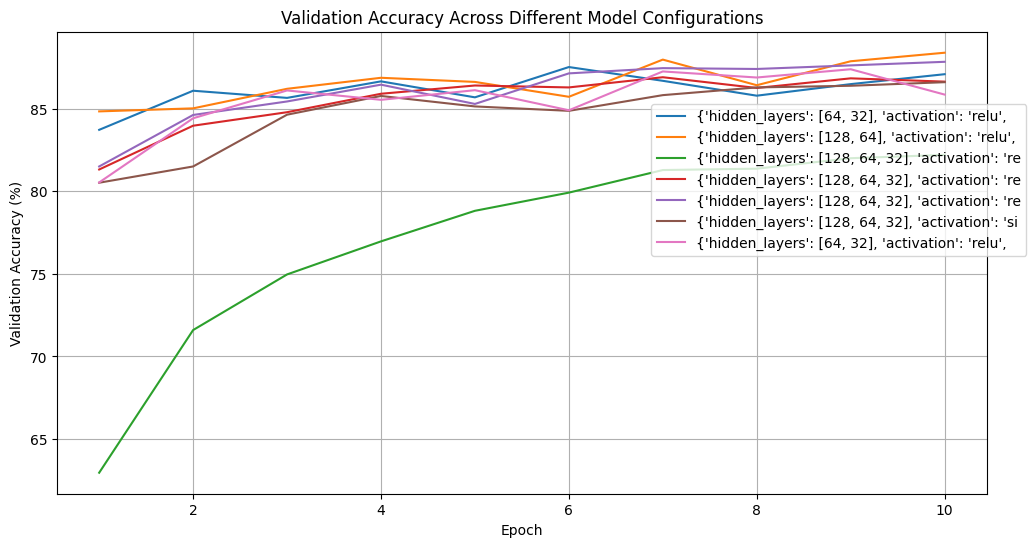

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracy for each experiment
plt.figure(figsize=(12, 6))

for config_name, results in experiment_results.items():  # Access the dictionary with results
    val_acc = results['val_accuracies']  # Access the 'val_accuracies' list
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=config_name[:50])  # Shortened config name

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Different Model Configurations")
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5))
plt.grid()
plt.show()


# Run the Model with Different Hyperparameters

In [ ]:
import torch

def compute_test_accuracy(model, test_loader, device):
    """
    Computes the accuracy of the given model on the test dataset.

    Parameters:
    - model: The neural network model to evaluate.
    - test_loader: DataLoader for the test dataset.
    - device: The device (CPU or GPU) to perform computations on.

    Returns:
    - test_accuracy: Accuracy of the model on the test dataset as a percentage.
    """
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

    test_accuracy = (correct_predictions / total_samples) * 100
    return test_accuracy


In [ ]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [ ]:
# Dictionary to store test accuracies for each model configuration
test_accuracies = {}

for config_name, model_data in experiment_results.items():
    model = model_data['model']  # Retrieve the trained model
    accuracy = compute_test_accuracy(model, test_loader, device)
    test_accuracies[config_name] = accuracy
    print(f"Test Accuracy for {config_name}: {accuracy:.2f}%")


Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier'}: 86.61%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier'}: 87.50%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier'}: 81.65%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'momentum', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier'}: 86.15%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'nesterov', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier'}: 86.75%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier'}: 85.65%
Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'rmsprop', '

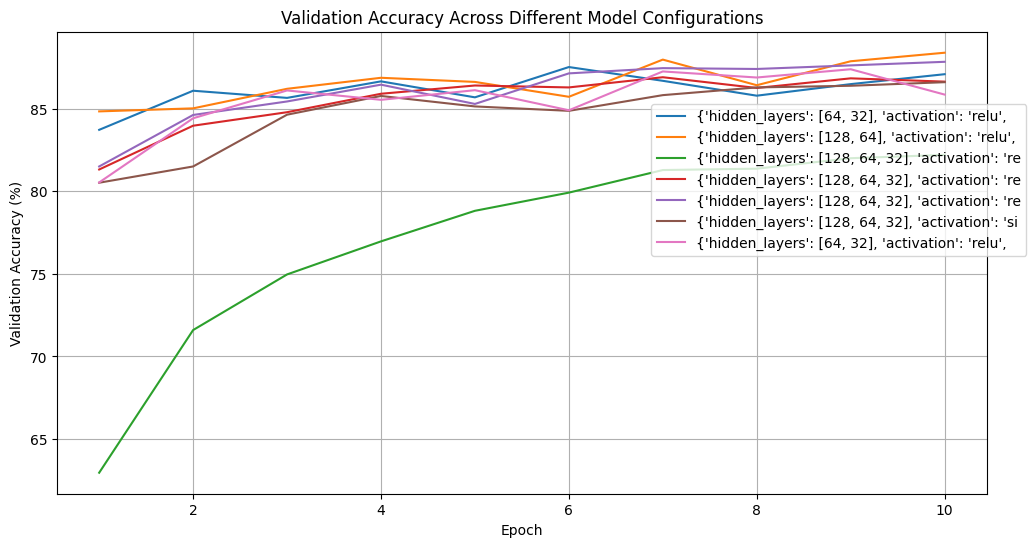

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracy for each experiment
plt.figure(figsize=(12, 6))

for config_name, results in experiment_results.items():  # Access the dictionary with results
    val_acc = results['val_accuracies']  # Access the 'val_accuracies' list
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=config_name[:50])  # Shortened config name

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Different Model Configurations")
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5))
plt.grid()
plt.show()

In [ ]:
best_model_config = "{'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier'}"  # Update to match the actual key in experiment_results
# Access the validation accuracy, assuming 'val_accuracies' is the key storing it
best_val_accuracy = experiment_results[best_model_config]["val_accuracies"][-1]

print(f"Best Model Validation Accuracy: {best_val_accuracy:.2f}%")

Best Model Validation Accuracy: 88.38%


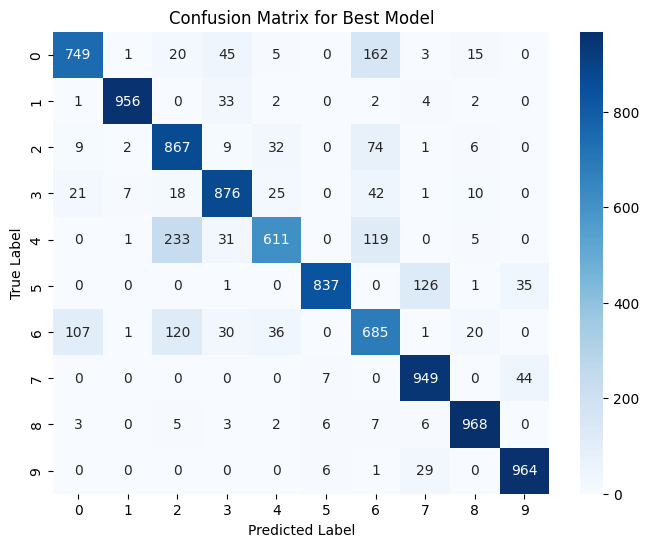

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on test set
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()
